<a href="https://colab.research.google.com/github/tithi31-rgb/P2P_Solar_Microgrid_App/blob/main/Module_2_P2P_Energy_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


In [18]:
class House:
    """
    This class represents one house in the microgrid.
    Each house can produce energy, consume energy,
    and trade surplus energy with other houses.
    """

    def __init__(self, house_id, energy_produced, energy_consumed):
        self.house_id = house_id
        self.energy_produced = energy_produced      # kWh generated
        self.energy_consumed = energy_consumed      # kWh used
        self.energy_balance = energy_produced - energy_consumed
        self.credits = 100                           # initial credits


In [20]:
house1 = House(house_id=1, energy_produced=18, energy_consumed=10)
house2 = House(house_id=2, energy_produced=6,  energy_consumed=14)
house3 = House(house_id=3, energy_produced=12, energy_consumed=9)

houses = [house1, house2, house3]


In [21]:
print("INITIAL STATUS OF HOUSES\n")

for h in houses:
    print(f"House {h.house_id}")
    print(" Energy Produced :", h.energy_produced, "kWh")
    print(" Energy Consumed :", h.energy_consumed, "kWh")
    print(" Energy Balance  :", h.energy_balance, "kWh")
    print(" Credits         :", h.credits)
    print("-" * 30)


INITIAL STATUS OF HOUSES

House 1
 Energy Produced : 18 kWh
 Energy Consumed : 10 kWh
 Energy Balance  : 8 kWh
 Credits         : 100
------------------------------
House 2
 Energy Produced : 6 kWh
 Energy Consumed : 14 kWh
 Energy Balance  : -8 kWh
 Credits         : 100
------------------------------
House 3
 Energy Produced : 12 kWh
 Energy Consumed : 9 kWh
 Energy Balance  : 3 kWh
 Credits         : 100
------------------------------


In [22]:
# List to store all energy transactions
transaction_ledger = []

def perform_energy_trade(seller, buyer, energy_amount):
    """
    Transfers energy from seller to buyer
    and updates credit balances.
    """

    CREDIT_PER_KWH = 2
    credits_required = energy_amount * CREDIT_PER_KWH

    # Update energy balances
    seller.energy_balance -= energy_amount
    buyer.energy_balance += energy_amount

    # Update credits
    seller.credits += credits_required
    buyer.credits -= credits_required

    # Record transaction
    transaction_ledger.append({
        "Seller House": seller.house_id,
        "Buyer House": buyer.house_id,
        "Energy Transferred (kWh)": energy_amount,
        "Credits Exchanged": credits_required
    })


In [23]:
# Identify surplus and deficit houses
surplus_houses = [h for h in houses if h.energy_balance > 0]
deficit_houses = [h for h in houses if h.energy_balance < 0]

# Perform trading
for seller in surplus_houses:
    for buyer in deficit_houses:
        if seller.energy_balance > 0 and buyer.energy_balance < 0:
            trade_energy = min(seller.energy_balance, abs(buyer.energy_balance))
            perform_energy_trade(seller, buyer, trade_energy)


In [24]:
print("\nP2P ENERGY TRADING LEDGER\n")

ledger_df = pd.DataFrame(transaction_ledger)
ledger_df



P2P ENERGY TRADING LEDGER



,Seller House,Buyer House,Energy Transferred (kWh),Credits Exchanged
0,1,2,8,16


In [25]:
print("\nFINAL STATUS OF HOUSES\n")

for h in houses:
    print(f"House {h.house_id}")
    print(" Remaining Energy Balance :", h.energy_balance, "kWh")
    print(" Final Credits           :", h.credits)
    print("-" * 30)



FINAL STATUS OF HOUSES

House 1
 Remaining Energy Balance : 0 kWh
 Final Credits           : 116
------------------------------
House 2
 Remaining Energy Balance : 0 kWh
 Final Credits           : 84
------------------------------
House 3
 Remaining Energy Balance : 3 kWh
 Final Credits           : 100
------------------------------


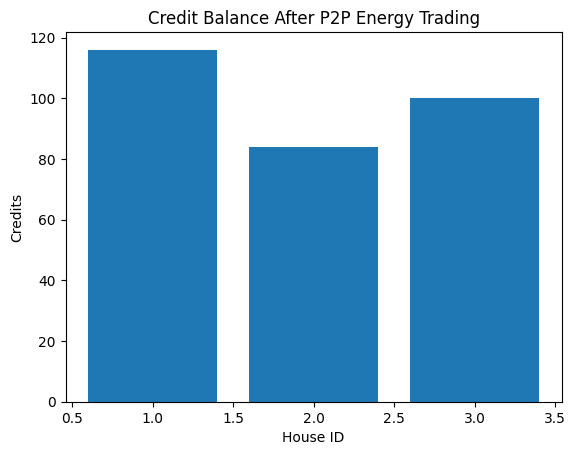

In [26]:
house_ids = [h.house_id for h in houses]
final_credits = [h.credits for h in houses]

plt.bar(house_ids, final_credits)
plt.xlabel("House ID")
plt.ylabel("Credits")
plt.title("Credit Balance After P2P Energy Trading")
plt.show()


In [27]:
from collections import deque
import time


In [28]:
"""
Mesh network representation:
Each house is connected to others.
This allows multiple paths for communication.
"""

mesh_network = {
    1: [2, 3],   # House 1 connected to House 2 and 3
    2: [1, 3],   # House 2 connected to House 1 and 3
    3: [1, 2]    # House 3 connected to House 1 and 2
}


In [29]:
print("MESH NETWORK TOPOLOGY\n")

for node, connections in mesh_network.items():
    print(f"House {node} is connected to houses {connections}")


MESH NETWORK TOPOLOGY

House 1 is connected to houses [2, 3]
House 2 is connected to houses [1, 3]
House 3 is connected to houses [1, 2]


In [30]:
def find_route(network, start_node, end_node):
    """
    Finds the shortest route between two houses
    using Breadth First Search (BFS).
    """
    queue = deque([[start_node]])
    visited = set()

    while queue:
        path = queue.popleft()
        current_node = path[-1]

        if current_node == end_node:
            return path

        if current_node not in visited:
            visited.add(current_node)
            for neighbor in network[current_node]:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)


In [31]:
route_1_to_3 = find_route(mesh_network, 1, 3)
print("Route from House 1 to House 3:", route_1_to_3)


Route from House 1 to House 3: [1, 3]


In [32]:
def send_message(network, source, destination, message):
    route = find_route(network, source, destination)

    print(f"\nMessage: '{message}'")
    print("Route taken:", route)

    for node in route:
        print(f"Data passing through House {node}")
        time.sleep(0.5)


In [33]:
send_message(
    mesh_network,
    source=1,
    destination=2,
    message="Surplus energy available for trading"
)



Message: 'Surplus energy available for trading'
Route taken: [1, 2]
Data passing through House 1
Data passing through House 2


In [34]:
failed_house = 2
print(f"\nHouse {failed_house} has failed!\n")

resilient_network = {
    node: [n for n in neighbors if n != failed_house]
    for node, neighbors in mesh_network.items()
    if node != failed_house
}

resilient_network



House 2 has failed!



{1: [3], 3: [1]}

In [35]:
new_route = find_route(resilient_network, 1, 3)
print("New route from House 1 to House 3 after failure:", new_route)


New route from House 1 to House 3 after failure: [1, 3]


In [36]:
communication_log = []

def log_message(source, destination, route):
    communication_log.append({
        "Source": source,
        "Destination": destination,
        "Route Used": route
    })

log_message(1, 3, new_route)
communication_log


[{'Source': 1, 'Destination': 3, 'Route Used': [1, 3]}]

In [40]:
house_data = {
    "House ID": [1, 2, 3],
    "Energy Balance (kWh)": [0, 0, 3],
    "Credits": [116, 84, 100]
}

house_df = pd.DataFrame(house_data)
house_df


,House ID,Energy Balance (kWh),Credits
0,1,0,116
1,2,0,84
2,3,3,100
